In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn import preprocessing
dtype = torch.float64
device = torch.device("cuda:0")
torch.manual_seed(42)
data = pd.read_csv("NN_training_big.nn")
np.random.seed(42)

In [2]:
data = data.set_index("Unnamed: 0")



In [3]:
data.iloc[0,0]

24.0

In [4]:
data = data.reset_index()
data.head()

,Unnamed: 0,Actual Velocity,Track Section,0_x,10_x,20_x,30_x,40_x,50_x,60_x,...,2500_y,2510_y,2520_y,2530_y,2540_y,2550_y,mean_acc_y,median_y,95_acc_y,max_acc_y
0,0,24.0,0.0,0.002890,0.002176,0.004270,0.007065,0.009169,0.008229,0.006080,...,0.001342,0.001679,0.001001,0.001741,0.001173,0.001034,0.441387,0.353673,1.135934,6.148501
1,2,25.0,0.0,0.006483,0.012145,0.016721,0.014323,0.019283,0.015196,0.018086,...,0.001500,0.001161,0.001255,0.001117,0.000859,0.001176,0.435271,0.328850,1.205422,6.901017
2,5,25.0,2580.0,0.006075,0.026636,0.049570,0.035475,0.045464,0.058989,0.035533,...,0.001636,0.000910,0.001677,0.001872,0.001693,0.001617,0.492657,0.398906,1.274077,2.885397
3,6,25.0,2580.0,0.006267,0.005948,0.009482,0.013067,0.011271,0.009465,0.012031,...,0.001607,0.001065,0.001259,0.001687,0.001401,0.001769,0.452549,0.330364,1.290717,3.406660
4,7,24.0,2580.0,0.006267,0.005948,0.009482,0.013067,0.011271,0.009465,0.012031,...,0.001607,0.001065,0.001259,0.001687,0.001401,0.001769,0.452549,0.330364,1.290717,3.406660


next cell is a little confusing
we scale the acceleration data (and not the target variables, actual velocity and track section)
then we add back in the target variable speed (not looking at position in this model).
Then we split into training, test and validate datasets.

In [5]:
x = data.iloc[:,3:].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
d2 = pd.DataFrame(x_scaled)
d2["speed"] = data.iloc[:,1].values
train, validate, test = np.split(d2.sample(frac=1), [int(.6*len(d2)), int(.8*len(d2))])

In [6]:
d2.head()

,0,1,2,3,4,5,6,7,8,9,...,511,512,513,514,515,516,517,518,519,speed
0,0.012894,0.010084,0.022370,0.039810,0.067396,0.061797,0.045177,0.056379,0.103754,0.134596,...,0.049948,0.020839,0.030925,0.016744,0.018857,0.043747,0.043857,0.041497,0.021361,24.0
1,0.032390,0.059556,0.089179,0.081217,0.142221,0.114948,0.135067,0.062820,0.131166,0.124973,...,0.034443,0.026175,0.019798,0.012231,0.021470,0.043136,0.040753,0.044054,0.023981,25.0
2,0.030172,0.131468,0.265445,0.201901,0.335917,0.449037,0.265696,0.289620,0.301918,0.199964,...,0.026947,0.035032,0.033254,0.024216,0.029571,0.048867,0.049511,0.046580,0.009997,25.0
3,0.031216,0.028804,0.050335,0.074051,0.082951,0.071224,0.089734,0.085961,0.228390,0.272376,...,0.031598,0.026260,0.029963,0.020023,0.032347,0.044862,0.040943,0.047193,0.011812,25.0
4,0.031216,0.028804,0.050335,0.074051,0.082951,0.071224,0.089734,0.085961,0.228390,0.272376,...,0.031598,0.026260,0.029963,0.020023,0.032347,0.044862,0.040943,0.047193,0.011812,24.0


In [7]:
y_tr = torch.from_numpy(train.iloc[:,-1].to_numpy())
y_tr = y_tr.view(y_tr.shape[0], 1)
y_te = torch.from_numpy(test.iloc[:,-1].to_numpy())
y_te = y_te.view(y_te.shape[0], 1)
y_va = torch.from_numpy(validate.iloc[:,-1].to_numpy())
y_va = y_va.view(y_va.shape[0], 1)

In [8]:
x_tr = torch.from_numpy(train.iloc[:,:-1].to_numpy())
x_te = torch.from_numpy(test.iloc[:,:-1].to_numpy())
x_va = torch.from_numpy(validate.iloc[:,:-1].to_numpy())

In [9]:
print(x_tr.shape, y_tr.shape)

torch.Size([10008, 520]) torch.Size([10008, 1])


In [10]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,511,512,513,514,515,516,517,518,519,speed
485,0.013801,0.044892,0.113802,0.178376,0.301623,0.167224,0.126587,0.158301,0.232646,0.195600,...,0.044672,0.026107,0.024301,0.036761,0.026343,0.083705,0.076614,0.086767,0.029065,38.0
8398,0.028837,0.035168,0.070129,0.082381,0.088652,0.115970,0.126023,0.035847,0.045223,0.043046,...,0.045091,0.040078,0.027772,0.023096,0.038960,0.120192,0.118210,0.115538,0.049316,66.0
2571,0.019712,0.019582,0.081202,0.086935,0.155120,0.114698,0.189383,0.144992,0.103995,0.057024,...,0.140108,0.090366,0.146999,0.095440,0.141284,0.304634,0.217707,0.381386,0.192331,79.0
14774,0.019306,0.028080,0.049760,0.065020,0.097671,0.051779,0.068423,0.030853,0.034626,0.019773,...,0.184284,0.079770,0.063068,0.063960,0.041093,0.091007,0.093789,0.085975,0.025356,65.0
5396,0.037723,0.081350,0.116759,0.157689,0.330517,0.237989,0.301501,0.269261,0.267445,0.095816,...,0.086822,0.069117,0.070014,0.076017,0.087131,0.246878,0.253661,0.226441,0.093765,79.0


In [11]:
x_tr[0]

tensor([0.0138, 0.0449, 0.1138, 0.1784, 0.3016, 0.1672, 0.1266, 0.1583, 0.2326,
        0.1956, 0.2777, 0.1348, 0.2416, 0.1878, 0.1444, 0.1688, 0.1344, 0.1670,
        0.1325, 0.0792, 0.1016, 0.1159, 0.1290, 0.0804, 0.1102, 0.0791, 0.1411,
        0.1004, 0.1436, 0.0731, 0.0940, 0.0458, 0.0695, 0.1099, 0.0930, 0.0743,
        0.0462, 0.0637, 0.0516, 0.0362, 0.0737, 0.0517, 0.0508, 0.0215, 0.0237,
        0.0380, 0.0238, 0.0174, 0.0266, 0.0300, 0.0245, 0.0259, 0.0185, 0.0717,
        0.0664, 0.0589, 0.0899, 0.1092, 0.0774, 0.0780, 0.0871, 0.0531, 0.1240,
        0.0776, 0.0798, 0.0686, 0.0476, 0.0323, 0.0354, 0.0381, 0.0414, 0.0378,
        0.0357, 0.0278, 0.0237, 0.0274, 0.0280, 0.0304, 0.0609, 0.0374, 0.0515,
        0.0381, 0.0621, 0.0314, 0.0348, 0.0482, 0.0406, 0.0341, 0.0341, 0.0213,
        0.0298, 0.0256, 0.0533, 0.0441, 0.0402, 0.0315, 0.0413, 0.0222, 0.0235,
        0.0230, 0.0149, 0.0272, 0.0220, 0.0233, 0.0316, 0.0269, 0.0364, 0.0287,
        0.0311, 0.0381, 0.0357, 0.0274, 

In [12]:
x_tr = x_tr.float()
y_tr = y_tr.float()
x_tr.shape

torch.Size([10008, 520])

In [13]:
x3d = x_tr.view(x_tr.shape[0],1,x_tr.shape[1])
x3d.shape

torch.Size([10008, 1, 520])

In [14]:
x_sq = torch.flatten(x3d, start_dim = 1)
x_sq.shape

torch.Size([10008, 520])

In [15]:
x_sq[0,-1] == x3d[0,0,-1]

tensor(True)

In [16]:
x3d[0,0,0:10]

tensor([0.0138, 0.0449, 0.1138, 0.1784, 0.3016, 0.1672, 0.1266, 0.1583, 0.2326,
        0.1956])

In [17]:
x_sq[0,0:10]

tensor([0.0138, 0.0449, 0.1138, 0.1784, 0.3016, 0.1672, 0.1266, 0.1583, 0.2326,
        0.1956])

In [18]:
m = torch.nn.Conv1d(1,1,5)

In [19]:
output = m(x3d)
output.shape

torch.Size([10008, 1, 516])

In [20]:
x_tr = x_tr.cuda()
y_tr = y_tr.cuda()

In [21]:
x_te = x_te.float().cuda()
y_te = y_te.float().cuda()

In [22]:
x_va = x_te.float().cuda()
y_va = y_te.float().cuda()

In [23]:
l_rate = 1e-6

input_dim, hiden_dim, h2, h3, h4, h5, h6, output_dim = 520, 250, 250, 125, 125, 30, 30, y_tr.shape[1]
model = torch.nn.Sequential(
#     torch.nn.Conv1d(1,1,5),
#     torch.nn.ReLU(),
#     torch.nn.Flatten(start_dim =1),
    torch.nn.Linear(input_dim, hiden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hiden_dim, h2),
    torch.nn.ReLU(),
    torch.nn.Linear(h2, h3),
    torch.nn.ReLU(),
    torch.nn.Linear(h3, h4),
    torch.nn.ReLU(),
    torch.nn.Linear(h4, h5),
    torch.nn.ReLU(),
    torch.nn.Linear(h5, h6),
    torch.nn.ReLU(),
    torch.nn.Linear(h6, output_dim),
)
model.cuda()
loss_fn = torch.nn.MSELoss(reduction="sum")
losses_train = []
losses_test = []
times = []

In [24]:
x_tr_3d = x_tr.view(x_tr.shape[0], 1, x_tr.shape[1])
x_te_3d = x_te.view(x_te.shape[0], 1, x_te.shape[1])
x_va_3d = x_va.view(x_va.shape[0], 1, x_va.shape[1])
losses_train = []
losses_test = []
times = []

In [25]:
x_tr_3d.shape

torch.Size([10008, 1, 520])

training error:     99  29027.125
test error:         99  56819.914
training error:   1099  28223.393
test error:       1099  56745.359
training error:   2099  27102.459
test error:       2099  56617.703
training error:   3099  25900.334
test error:       3099  56478.297
training error:   4099  24709.824
test error:       4099  56267.891
training error:   5099  23620.596
test error:       5099  56075.281
training error:   6099  22613.969
test error:       6099  55965.938
training error:   7099  21662.375
test error:       7099  55863.395
training error:   8099  20760.205
test error:       8099  55804.324
training error:   9099  19908.992
test error:       9099  55744.633
training error:  10099  19104.369
test error:      10099  55731.586
training error:  11099  18344.496
test error:      11099  55723.562
training error:  12099  17624.803
test error:      12099  55720.484
training error:  13099  16951.850
test error:      13099  55723.875
training error:  14099  16315.133
test error:   

<AxesSubplot:xlabel='time', ylabel='test_l'>

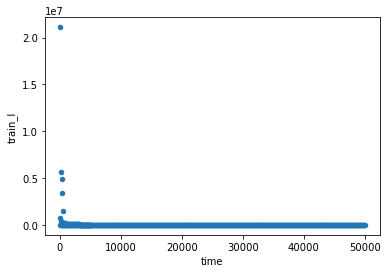

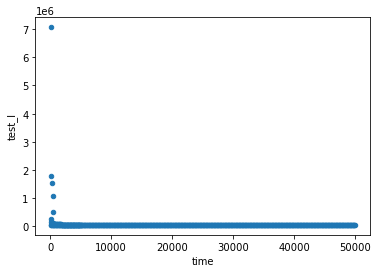

In [53]:
# scheduler = optim.X(optimizer,...)      # create lr scheduler
# scheduler.step()                        # update lr at start of epoch
# optim.lr_scheduler.X                    # where X is LambdaLR, StepLR, MultiStepLR,
              # ExponentialLR or ReduceLROnPLateau
learning_rate = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.2, verbose = True)
for t in range(50000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_tr)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_tr)
    if t % 1000 == 99:
        print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model(x_te)
        loss_te = loss_fn(y_test, y_te)
        print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
    if t % 100 == 99:
#         print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model(x_te)
        loss_te = loss_fn(y_test, y_te)
#         print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
        losses_train.append(loss.item())
        losses_test.append(loss_te.item())
        times.append(t)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
#     scheduler.step(loss)
stats = pd.DataFrame({"train_l":losses_train, "test_l":losses_test, "time":times})
# stats.plot(x="time", y=["train_l", "test_l"], kind="scatter")
stats.plot(x="time", y="train_l", kind="scatter")
stats.plot(x="time", y="test_l", kind="scatter")

<AxesSubplot:xlabel='time', ylabel='test_l'>

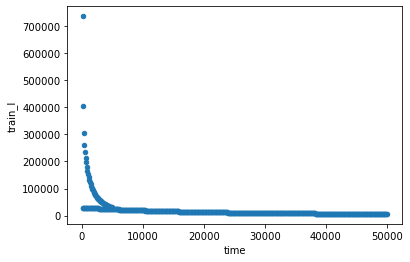

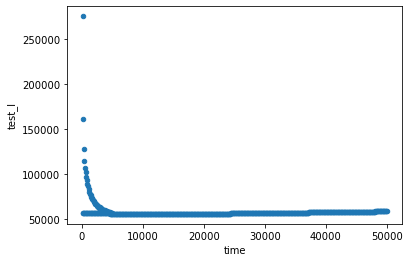

In [54]:
stats.iloc[5:,:].plot(x="time", y="train_l", kind="scatter")
stats.iloc[5:,:].plot(x="time", y="test_l", kind="scatter")

<AxesSubplot:xlabel='time', ylabel='test_l'>

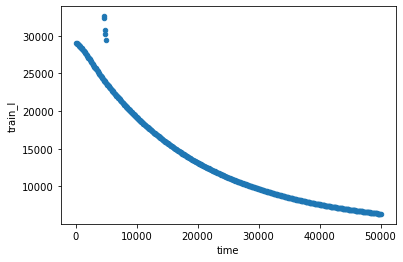

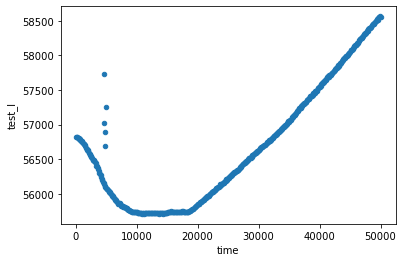

In [55]:
stats.iloc[50:,:].plot(x="time", y="train_l", kind="scatter")
stats.iloc[50:,:].plot(x="time", y="test_l", kind="scatter")

In [29]:
from ray import tune

In [30]:
# l_rate = 1e-5

In [31]:

# for t in range(500):
# #     y_pred = model(xc).to(device)
#     y_pred = model(x_tr)
    
# #     y_c_pred = y_pred.to(dev)
#     loss = loss_fn(y_pred, y_tr)
    
#     if t % 1000 == 99:
#         print("{:16}{:6}   {:5.3}".format("training error:", t, loss.item()))
#         y_test = model(x_te)
#         loss_te = loss_fn(y_test, y_te)
#         print("{:16}{:6}  {:5.3}".format("test error:", t, loss_te.item()))
#     if t % 100 == 1:
# #         print("training error:", t, loss.item())
#         y_test = model(x_te)
#         loss_te = loss_fn(y_test, y_te)
# #         print("test error:", t, loss_te.item())
#         losses_train.append(loss.item())
#         losses_test.append(loss_te.item())
#         times.append(t)
#     model.zero_grad()
#     loss.backward()
#     with torch.no_grad():
#         for param in model.parameters():
#             param -= l_rate * param.grad

In [32]:
# stats = pd.DataFrame({"train_l":losses_train, "test_l":losses_test, "time":times})
# # stats.plot(x="time", y=["train_l", "test_l"], kind="scatter")
# stats.plot(x="time", y="train_l", kind="scatter")
# stats.plot(x="time", y="test_l", kind="scatter")

to do:
    Randomize the order of the input data
    training/test set split
    optimise architecture
    test by plotting predicted speeds of other runs
    investigate 1d convolution layer
    print the validation set score with loss
    
    Build alternate model using raw acceleration data (down sample data) - investigate embedding/embedding layer

In [33]:
# checkpoint = {'input_size': xc.shape[1],
#               'output_size': yc.shape[1],
#               "model_dets": model,
#               'state_dict': model.state_dict()}

# torch.save(checkpoint, 'checkpoint.pth')

In [34]:
model

Sequential(
  (0): Linear(in_features=520, out_features=250, bias=True)
  (1): ReLU()
  (2): Linear(in_features=250, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=125, bias=True)
  (5): ReLU()
  (6): Linear(in_features=125, out_features=125, bias=True)
  (7): ReLU()
  (8): Linear(in_features=125, out_features=30, bias=True)
  (9): ReLU()
  (10): Linear(in_features=30, out_features=30, bias=True)
  (11): ReLU()
  (12): Linear(in_features=30, out_features=1, bias=True)
)

In [35]:
df1 = pd.read_csv("01-08-19-V118_ch1.big" , index_col = 0)
df2 = pd.read_csv("01-08-19-V118_ch2.big" , index_col = 0)

In [36]:
df1 = df1.reset_index()
df2 = df2.reset_index()

In [37]:
df = pd.merge(df1, df2, how = "outer", on = "index")
df.head()

,index,0_x,10_x,20_x,30_x,40_x,50_x,60_x,70_x,80_x,...,2500_y,2510_y,2520_y,2530_y,2540_y,2550_y,mean_acc_y,median_y,95_acc_y,max_acc_y
0,0,0.002283,0.001861,0.001776,0.002652,0.004631,0.009036,0.007076,0.006394,0.007697,...,0.002245,0.001517,0.001681,0.001096,0.001384,0.001165,1.198058,0.982748,3.083282,7.179362
1,1,0.002964,0.002919,0.003401,0.003421,0.005504,0.007987,0.007737,0.006090,0.006359,...,0.001800,0.001058,0.001129,0.001639,0.001557,0.001575,1.226540,1.033503,3.092825,6.464596
2,2,0.004012,0.003644,0.004012,0.004476,0.006040,0.007929,0.008039,0.007646,0.011035,...,0.000736,0.001267,0.001046,0.001271,0.000913,0.001316,1.040367,0.884531,2.612213,5.477276
3,3,0.001981,0.002050,0.003021,0.002484,0.004625,0.006709,0.007154,0.006420,0.006462,...,0.001464,0.001167,0.001430,0.001136,0.001324,0.000884,1.173504,1.040558,2.719463,5.129313
4,4,0.001982,0.001520,0.002056,0.002422,0.006100,0.005771,0.007166,0.006682,0.012416,...,0.001787,0.001507,0.001729,0.001084,0.001341,0.001238,1.194421,0.971220,3.084037,7.484677


In [38]:
x_ch = torch.from_numpy(min_max_scaler.transform(df.iloc[:,1:].values))
x_ch[0,0]

tensor(0.0096, dtype=torch.float64)

In [39]:
x_ch = x_ch.float()
x_ch[0,0]

tensor(0.0096)

In [40]:
x_ch = x_ch.to(device)
x_ch[0,0]

tensor(0.0096, device='cuda:0')

In [41]:
x_ch.device

device(type='cuda', index=0)

In [42]:
x_ch.shape

torch.Size([10030, 520])

In [43]:
x_ch_3d = x_ch.view(x_ch.shape[0], 1, x_ch.shape[1])
x_ch_3d.shape

torch.Size([10030, 1, 520])

In [44]:
y_ch = model(x_ch_3d)

In [45]:
y_ch.shape

torch.Size([10030, 1, 1])

In [46]:
ch_np = y_ch.cpu().detach().numpy()
type(ch_np)

numpy.ndarray

In [47]:
ch_np.shape

(10030, 1, 1)

In [48]:
df4 = pd.DataFrame(min_max_scaler.fit_transform(df.iloc[:,1:].values))

In [49]:
df4["speed"] = ch_np

ValueError: Wrong number of dimensions. values.ndim != ndim [3 != 2]

In [ ]:
df4.head()

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
df4.plot("speed")

In [ ]:
plotdf = df4.reset_index()

In [ ]:
plotdf.head()

In [ ]:
plt.figure(figsize= (30, 30))
g = sb.scatterplot(x = "index", y = "speed", data = plotdf, alpha = 0.2, color ="b")
g = sb.scatterplot(x = "index", y = data.iloc[:,-2], data = plotdf, alpha = 0.2, color ="r")

In [ ]:
plt.figure(figsize= (30, 30))
sb.lineplot(x = "index", y = "speed", data = plotdf.iloc[0:1000,:], color ="b")
# sb.lineplot(x = "index", y = "speed", data = plotdf.iloc[0:1000,:], alpha = 0.2, color ="b")

In [ ]:
plt.figure(figsize= (30, 30))
g = sb.lineplot(x = "index", y = "speed", data = plotdf, alpha = 0.2, color ="b")
g = sb.lineplot(x = "index", y = data.iloc[:,-2], data = plotdf, alpha = 0.2, color ="r")